In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE

# Configure visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Define paths
MODELS_DIR = '../models'
BEST_MODEL_PATH = os.path.join(MODELS_DIR, 'best_churn_model.pkl')

In [2]:
# Cell 2: Load Preprocessed Data
try:
    X_train = pd.read_csv(os.path.join(MODELS_DIR, 'X_train_processed.csv'))
    X_test = pd.read_csv(os.path.join(MODELS_DIR, 'X_test_processed.csv'))
    y_train = pd.read_csv(os.path.join(MODELS_DIR, 'y_train.csv'))['Churn'] # Read as Series
    y_test = pd.read_csv(os.path.join(MODELS_DIR, 'y_test.csv'))['Churn']   # Read as Series
    print("Preprocessed data loaded successfully.")
    print("X_train shape:", X_train.shape)
    print("y_train class distribution:\n", y_train.value_counts(normalize=True))
except FileNotFoundError:
    print("Error: Preprocessed data files not found. Please run Notebook 01 first.")
    # Set to None to prevent further errors
    X_train, X_test, y_train, y_test = None, None, None, None 

Preprocessed data loaded successfully.
X_train shape: (5634, 30)
y_train class distribution:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


In [3]:
# Cell 3: Handle Imbalanced Data (SMOTE on Training Set Only)
if X_train is not None:
    print("Original training set shape - Churn counts:\n", y_train.value_counts())

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    print("\nResampled training set shape - Churn counts:\n", y_train_resampled.value_counts())
    print("X_train_resampled shape:", X_train_resampled.shape)
else:
    print("Skipping SMOTE due to data loading failure.")

Original training set shape - Churn counts:
 Churn
0    4139
1    1495
Name: count, dtype: int64

Resampled training set shape - Churn counts:
 Churn
0    4139
1    4139
Name: count, dtype: int64
X_train_resampled shape: (8278, 30)


In [4]:
# Cell 4: Define Models and Evaluation Function
if X_train is not None:
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
        # "SVM": SVC(probability=True, random_state=42) # Can be slow without hyperparameter tuning & on large data
    }

    results = {}

    def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
        print(f"--- Training {name} ---")
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)
        y_pred_proba = model.predict_proba(X_te)[:, 1]

        print(f"\n--- {name} Evaluation on Test Set ---")
        accuracy = accuracy_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred)
        recall = recall_score(y_te, y_pred)
        f1 = f1_score(y_te, y_pred)
        roc_auc = roc_auc_score(y_te, y_pred_proba)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision (for Churn=1): {precision:.4f}")
        print(f"Recall (for Churn=1): {recall:.4f}")
        print(f"F1-score (for Churn=1): {f1:.4f}")
        print(f"ROC AUC Score: {roc_auc:.4f}")
        print("\nClassification Report:\n", classification_report(y_te, y_pred))
        
        cm = confusion_matrix(y_te, y_pred)
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return {'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'roc_auc': roc_auc}

else:
    print("Skipping model definition due to data loading failure.")

--- Training Logistic Regression ---

--- Logistic Regression Evaluation on Test Set ---
Accuracy: 0.7353
Precision (for Churn=1): 0.5009
Recall (for Churn=1): 0.7246
F1-score (for Churn=1): 0.5923
ROC AUC Score: 0.8267

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      1035
           1       0.50      0.72      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409



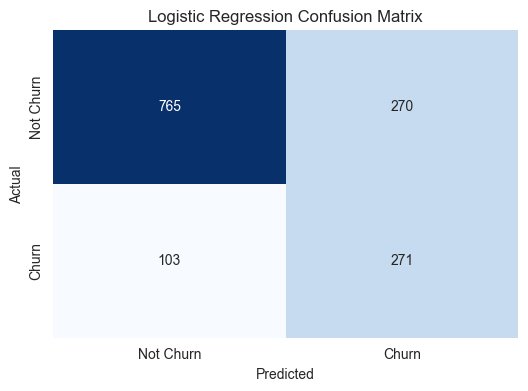

--- Training Decision Tree ---

--- Decision Tree Evaluation on Test Set ---
Accuracy: 0.7119
Precision (for Churn=1): 0.4651
Recall (for Churn=1): 0.5695
F1-score (for Churn=1): 0.5120
ROC AUC Score: 0.6662

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.80      1035
           1       0.47      0.57      0.51       374

    accuracy                           0.71      1409
   macro avg       0.65      0.67      0.65      1409
weighted avg       0.73      0.71      0.72      1409



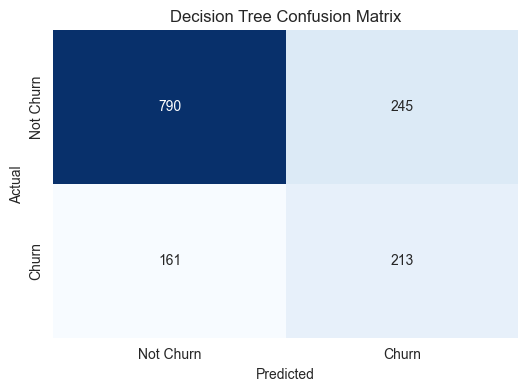

--- Training Random Forest ---

--- Random Forest Evaluation on Test Set ---
Accuracy: 0.7665
Precision (for Churn=1): 0.5527
Recall (for Churn=1): 0.6310
F1-score (for Churn=1): 0.5893
ROC AUC Score: 0.8213

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.55      0.63      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409



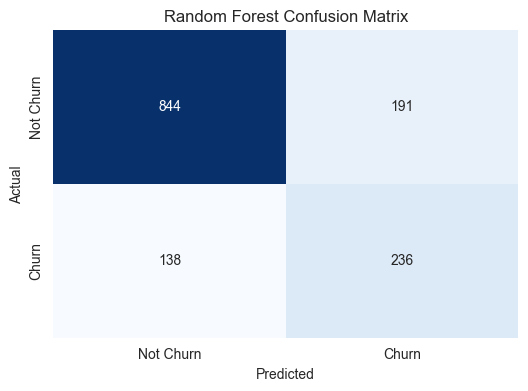

--- Training XGBoost ---

--- XGBoost Evaluation on Test Set ---
Accuracy: 0.7566
Precision (for Churn=1): 0.5348
Recall (for Churn=1): 0.6364
F1-score (for Churn=1): 0.5812
ROC AUC Score: 0.8019

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1035
           1       0.53      0.64      0.58       374

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.76      0.76      1409



d:\Programming\customer-churn-prediction-webapp\ccpenv\lib\site-packages\xgboost\training.py:183: UserWarning: [01:30:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


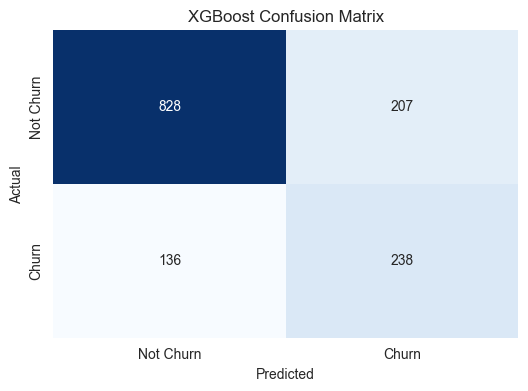

In [5]:
# Cell 5: Train and Evaluate Baseline Models
if X_train is not None:
    for name, model_instance in models.items():
        results[name] = evaluate_model(name, model_instance, X_train_resampled, y_train_resampled, X_test, y_test)
else:
    print("Skipping model training due to data loading failure.")


--- Model Performance Summary (Sorted by ROC_AUC) ---


,Model,ROC_AUC,Recall,Precision,F1-Score
0,Logistic Regression,0.826689,0.724599,0.500924,0.592350
2,Random Forest,0.821339,0.631016,0.552693,0.589263
3,XGBoost,0.801923,0.636364,0.534831,0.581197
1,Decision Tree,0.666194,0.569519,0.465066,0.512019


C:\Users\prath\AppData\Local\Temp\ipykernel_10596\1445239010.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ROC_AUC', y='Model', data=performance_df, palette='viridis')


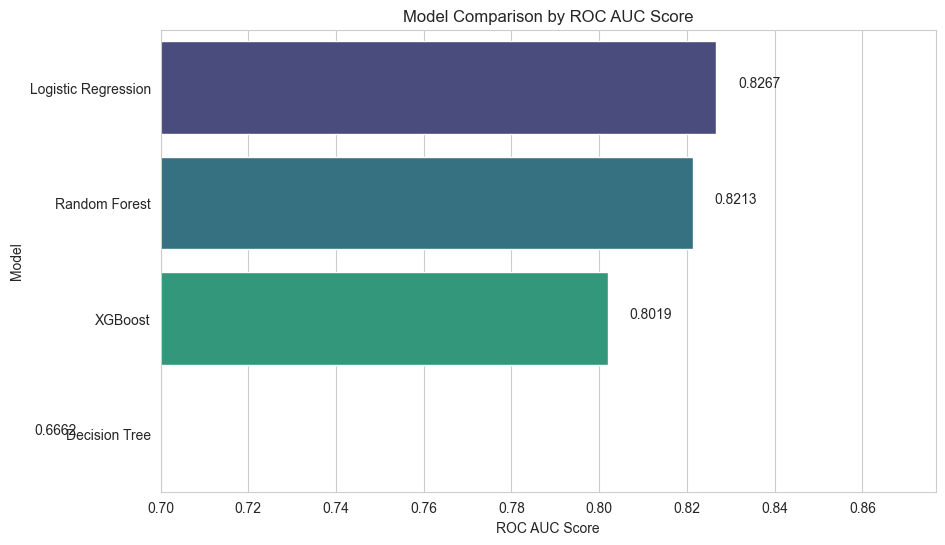

In [6]:
# Cell 6: Compare Model Performances
if X_train is not None and results:
    performance_df = pd.DataFrame([(name, res['roc_auc'], res['recall'], res['precision'], res['f1']) 
                                   for name, res in results.items()],
                                  columns=['Model', 'ROC_AUC', 'Recall', 'Precision', 'F1-Score'])
    performance_df = performance_df.sort_values(by='ROC_AUC', ascending=False)
    
    print("\n--- Model Performance Summary (Sorted by ROC_AUC) ---")
    display(performance_df)

    # Plotting ROC AUC for comparison
    plt.figure(figsize=(10,6))
    sns.barplot(x='ROC_AUC', y='Model', data=performance_df, palette='viridis')
    plt.title('Model Comparison by ROC AUC Score')
    plt.xlabel('ROC AUC Score')
    plt.ylabel('Model')
    plt.xlim(0.7, performance_df['ROC_AUC'].max() + 0.05 if not performance_df.empty else 1.0) # Adjust xlim for better viz
    for index, value in enumerate(performance_df['ROC_AUC']):
        plt.text(value + 0.005, index, f'{value:.4f}')
    plt.show()
else:
    print("Skipping performance comparison due to no results or data issues.")

In [7]:
# Cell 7: Hyperparameter Tuning for the Best Candidate Model (Example: XGBoost or RandomForest)
# Let's assume XGBoost or Random Forest are good candidates based on initial results
if X_train is not None and results:
    best_candidate_name = performance_df.iloc[0]['Model'] # Get the top model by ROC AUC
    print(f"\n--- Hyperparameter Tuning for {best_candidate_name} ---")

    if "XGBoost" in best_candidate_name:
        param_grid_xgb = {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.7, 0.8]
        }
        xgb_tuned = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
        grid_search = GridSearchCV(estimator=xgb_tuned, param_grid=param_grid_xgb, 
                                   cv=StratifiedKFold(n_splits=3), scoring='roc_auc', verbose=1, n_jobs=-1)
    
    elif "Random Forest" in best_candidate_name:
        param_grid_rf = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            # 'class_weight': ['balanced', 'balanced_subsample'] # Already used SMOTE
        }
        rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
        grid_search = GridSearchCV(estimator=rf_tuned, param_grid=param_grid_rf, 
                                   cv=StratifiedKFold(n_splits=3), scoring='roc_auc', verbose=1, n_jobs=-1)
    else:
        print(f"No specific tuning grid for {best_candidate_name}. Using the baseline model.")
        grid_search = None # No tuning, use the previously trained model from results
        tuned_model = results[best_candidate_name]['model']

    if grid_search:
        grid_search.fit(X_train_resampled, y_train_resampled)
        print(f"Best parameters for {best_candidate_name}: {grid_search.best_params_}")
        print(f"Best ROC AUC from GridSearchCV: {grid_search.best_score_:.4f}")
        tuned_model = grid_search.best_estimator_
        
        # Evaluate the tuned model
        print(f"\n--- Evaluation of Tuned {best_candidate_name} ---")
        results[f"Tuned {best_candidate_name}"] = evaluate_model(f"Tuned {best_candidate_name}", tuned_model, 
                                                                 X_train_resampled, y_train_resampled, # Fitting is done by GS
                                                                 X_test, y_test) # Just predict
else:
    print("Skipping hyperparameter tuning.")


--- Hyperparameter Tuning for Logistic Regression ---
No specific tuning grid for Logistic Regression. Using the baseline model.



--- Final Best Model: Logistic Regression ---
ROC AUC: 0.8267
Final best model ('Logistic Regression') saved to ../models\best_churn_model.pkl


C:\Users\prath\AppData\Local\Temp\ipykernel_10596\911094497.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=feature_importance_df.sort_values('coefficient', ascending=False), palette='coolwarm')


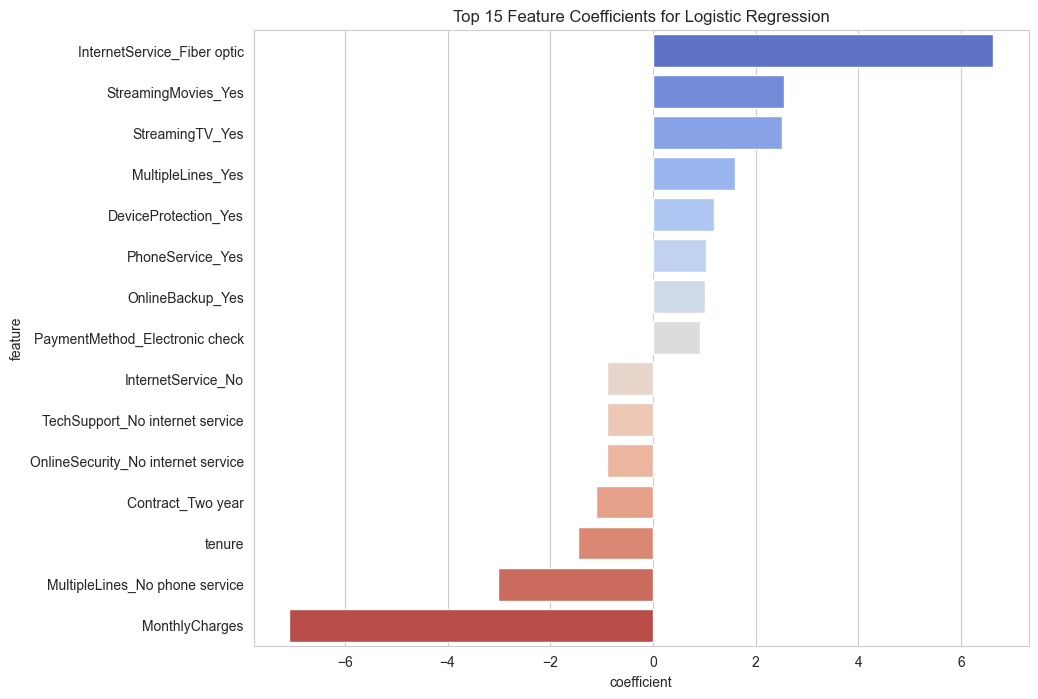

In [8]:
# Cell 8: Select and Save the Final Best Model
if X_train is not None and results:
    # Determine the overall best model (could be tuned or baseline)
    final_best_model_name = ""
    highest_roc_auc = 0
    final_best_model_object = None

    for name, res_dict in results.items():
        if res_dict['roc_auc'] > highest_roc_auc:
            highest_roc_auc = res_dict['roc_auc']
            final_best_model_name = name
            final_best_model_object = res_dict['model']
            
    if final_best_model_object:
        print(f"\n--- Final Best Model: {final_best_model_name} ---")
        print(f"ROC AUC: {highest_roc_auc:.4f}")
        
        # Save the final best model
        joblib.dump(final_best_model_object, BEST_MODEL_PATH)
        print(f"Final best model ('{final_best_model_name}') saved to {BEST_MODEL_PATH}")

        # Feature Importance (if applicable)
        if hasattr(final_best_model_object, 'feature_importances_'):
            importances = final_best_model_object.feature_importances_
            feature_names = X_train_resampled.columns 
            feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
            feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15)
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='mako')
            plt.title(f'Top 15 Feature Importances for {final_best_model_name}')
            plt.show()
        elif hasattr(final_best_model_object, 'coef_') and "Logistic Regression" in final_best_model_name:
            # For Logistic Regression, coefficients
            coefficients = final_best_model_object.coef_[0]
            feature_names = X_train_resampled.columns
            feature_importance_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
            # Take absolute value for ranking, but display original for interpretation
            feature_importance_df['abs_coefficient'] = np.abs(feature_importance_df['coefficient'])
            feature_importance_df = feature_importance_df.sort_values('abs_coefficient', ascending=False).head(15)

            plt.figure(figsize=(10, 8))
            sns.barplot(x='coefficient', y='feature', data=feature_importance_df.sort_values('coefficient', ascending=False), palette='coolwarm')
            plt.title(f'Top 15 Feature Coefficients for {final_best_model_name}')
            plt.show()
    else:
        print("No best model selected or error occurred.")
else:
    print("Skipping model saving due to data/results issues.")